<a href="https://colab.research.google.com/github/stefisha/NordeusChallenge/blob/main/NordeusChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nordeus Data Science Challenge (for JobFair 2023)
Submission for the challenge explained [here](https://nordeus.com/data-science-challenge/).

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [75]:
# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Nordeus Challenge/jobfair_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Nordeus Challenge/jobfair_test.csv')

In [76]:
test_data.head()

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,playtime_last_28_days,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash
0,174,14542747,2951383,0) NonPayer,1,23,4.295345,4.100333,0.469406,8,...,2580346,France,iOS Phone,10,6,NaN,82,18,177,106
1,174,11019672,2954266,0) NonPayer,21,24,4.704727,4.484933,0.317702,28,...,15521681,Indonesia,Android Phone,16,26,7.0,153,65,1030,717
2,174,14358567,2951259,0) NonPayer,2,22,2.923867,2.819171,0.669540,0,...,0,Brazil,Android Phone,7,0,NaN,0,138,156,98
3,174,14644461,2949546,0) NonPayer,1,22,3.114776,2.977457,0.639923,3,...,1136208,Spain,Android Phone,2,1,NaN,2,43,43,25
4,174,13718978,2952772,0) NonPayer,6,23,4.194497,4.114257,0.486229,26,...,43655679,France,Android Phone,22,46,1.0,100,30,45,53


In [77]:
# Identify categorical and numerical columns
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [78]:
# Remove the target variable and identifiers from the numerical columns list
numerical_cols.remove('league_rank')
numerical_cols.remove('club_id')
numerical_cols.remove('league_id')

In [79]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
    #('scaler', StandardScaler()) # maybe unnecessary
])

In [80]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [81]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [82]:
# Separate target from predictors
X_train = train_data.drop(['club_id', 'league_id', 'league_rank'], axis=1)
y_train = train_data['league_rank']
X_test = test_data.drop(['club_id', 'league_id'], axis=1)

In [83]:
# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [84]:
# Convert the preprocessed training data to a DataFrame
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
feature_names = list(numerical_cols) + list(ohe_feature_names)
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed.toarray(), columns=feature_names)

In [85]:
# Define the model
model = RandomForestClassifier(random_state=0, n_estimators=100)

In [86]:
# Perform cross-validation
cv_scores = -1 * cross_val_score(model, X_train_preprocessed_df, y_train, cv=5, scoring='neg_mean_absolute_error')

In [87]:
# Print the mean and standard deviation of the cross-validation scores
print(f'Mean MAE: {cv_scores.mean()}')
print(f'Standard Deviation of MAE: {cv_scores.std()}')

Mean MAE: 2.8027443487687327
Standard Deviation of MAE: 0.013787625866332132


In [89]:
# from sklearn.tree import DecisionTreeClassifier

# # Define a simple Decision Tree Classifier
# dt_model = DecisionTreeClassifier(random_state=0)

# # Perform cross-validation to evaluate the model using Mean Absolute Error
# # We multiply by -1 because sklearn's cross-validation functions maximize utility functions, so they treat MAE as negative
# dt_cv_scores = -1 * cross_val_score(dt_model, X_train_preprocessed, y_train, cv=5, scoring='neg_mean_absolute_error')

# # Compute the mean and standard deviation of the cross-validation scores
# dt_cv_mae_mean = dt_cv_scores.mean()
# dt_cv_mae_std = dt_cv_scores.std()

# dt_cv_mae_mean, dt_cv_mae_std

In [90]:
# Adjust the target variable to start from 0
y_train_adjusted = y_train - 1

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=0, num_class=14)

# Perform cross-validation
xgb_cv_scores = -1 * cross_val_score(xgb_model, X_train_preprocessed, y_train_adjusted, cv=5, scoring='neg_mean_absolute_error')

# Compute the mean and standard deviation of the cross-validation scores
xgb_cv_mae_mean = xgb_cv_scores.mean()
xgb_cv_mae_std = xgb_cv_scores.std()

print(f"XGBoost Mean MAE: {xgb_cv_mae_mean}")
print(f"XGBoost Standard Deviation of MAE: {xgb_cv_mae_std}")

XGBoost Mean MAE: 2.795873931084169
XGBoost Standard Deviation of MAE: 0.022760493122285067


In [107]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.6),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}
# param_dist = { ## computationally too demanding
#     'n_estimators': randint(100, 1000),  # Wider range
#     'learning_rate': uniform(0.01, 0.1),  # Narrower range for more precision
#     'max_depth': randint(3, 15),  # Try deeper trees
#     'min_child_weight': randint(1, 6),
#     'gamma': uniform(0, 0.5),
#     'subsample': uniform(0.5, 0.5),
#     'colsample_bytree': uniform(0.5, 0.5)
# }


# Initialize XGBoost model
#xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=0, num_class=14)
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=0,
    # num_class=14,
    #early_stopping_rounds=10,
    eval_metric="mae",
    verbose=True
)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=0,
    verbose=3,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_preprocessed, y_train_adjusted)

# Print the best parameters and lowest MAE
print("Best parameters found: ", random_search.best_params_)
print("Lowest MAE found: ", -random_search.best_score_)

In [92]:
# Train the final model with the best parameters
final_xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    colsample_bytree=0.6044,
    gamma=0.0807,
    learning_rate=0.4019,
    max_depth=3,
    min_child_weight=5,
    n_estimators=277,
    subsample=0.8118,
    random_state=0,
    num_class=14
)

final_xgb_model.fit(X_train_preprocessed, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6044, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0807, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4019, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=277, n_jobs=None, num_class=14,
              num_parallel_tree=None, ...)

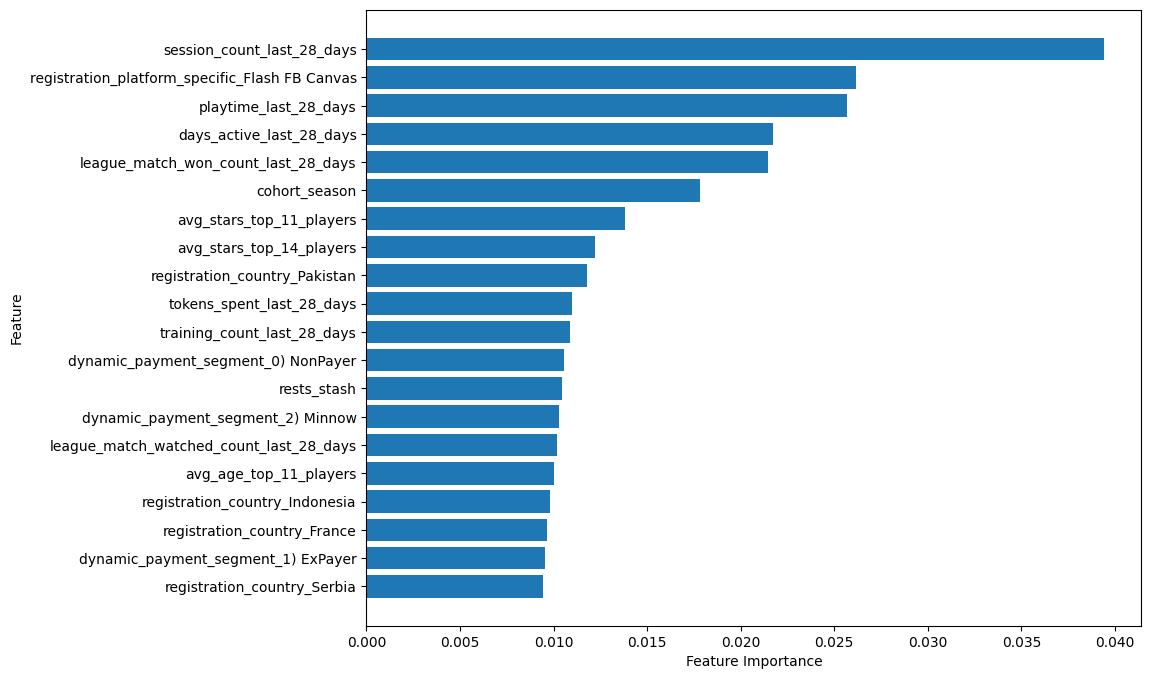

In [93]:
# Train the final model with the best parameters
final_xgb_model.fit(X_train_preprocessed, y_train_adjusted)

# Get feature importance
feature_importances = final_xgb_model.feature_importances_

# Sort features by their importance scores
sorted_idx = feature_importances.argsort()

# Select the top N features (e.g., top 20)
top_n = 20
sorted_idx_top = sorted_idx[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx_top)), feature_importances[sorted_idx_top], align='center')
plt.yticks(range(len(sorted_idx_top)), [feature_names[i] for i in sorted_idx_top])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


In [94]:
# Make predictions
predictions = final_xgb_model.predict(X_test_preprocessed)

# Adjust predictions back to original scale (because we subtracted 1 earlier)
predictions_adjusted = predictions + 1

In [95]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'club_id': test_data['club_id'],
    'predicted_league_rank': predictions_adjusted
})

# Display the first few rows of the submission DataFrame
submission.head()

,club_id,predicted_league_rank
0,14542747,10
1,11019672,4
2,14358567,7
3,14644461,11
4,13718978,2


In [96]:
# Save the DataFrame to a CSV file for submission
submission.to_csv('league_rank_predictions.csv', index=False)

In [97]:
# We can try LightGBM
# import lightgbm as lgb
# lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=14, random_state=0)
# lgb_cv_scores = -1 * cross_val_score(lgb_model, X_train_preprocessed, y_train_adjusted, cv=5, scoring='neg_mean_absolute_error')

In [98]:
# Turns out we get the same MAE
# lgb_cv_mae_mean = lgb_cv_scores.mean()
# lgb_cv_mae_std = lgb_cv_scores.std()

# print(f"XGBoost Mean MAE: {lgb_cv_mae_mean}")
# print(f"XGBoost Standard Deviation of MAE: {lgb_cv_mae_std}")

In [99]:
# We attempt combining RF with XGBoost however it takes far too long
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# estimators = [
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
#     ('xgb', xgb.XGBClassifier(objective='multi:softprob', num_class=14, random_state=0))
# ]
# stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000))

In [100]:
# from sklearn.model_selection import StratifiedKFold
# stratified_cv = StratifiedKFold(n_splits=5)
# scores = cross_val_score(stack_model, X_train_preprocessed, y_train_adjusted, cv=stratified_cv, scoring='neg_mean_absolute_error')

In [101]:
# # Compute the mean and standard deviation of the cross-validation scores
# stacked_mean = scores.mean()
# stacked_mae_std = cross_val_score.std()

# print(f"Stacking Mean MAE: {stacked_mean}")
# print(f"Stacking Standard Deviation of MAE: {stacked_mae_std}")